## Libraries import

In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from sklearn.model_selection import validation_curve


# Tree print
from sklearn.tree import export_graphviz

# warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  #hide any pandas warnings

sns.set(style="whitegrid", color_codes=True)

### Define utility functions

In [2]:
# Define confusion matrix function
def do_confusion_matrix(Y, prediction):
    cm = confusion_matrix(Y, prediction)
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm_df, annot=True, square=True, cmap="YlGnBu")
    plt.tight_layout()
    plt.show()
    print("Sensitivity (True Positives Rate):", np.round(cm[0,0]/(cm[0,0] + cm[1,0]), 2))
    print("Specificity (True Negatives Rate):", np.round(cm[1,1]/(cm[1,1] + cm[0,1]), 2))
    
# Define feature importance function
def do_feature_importance(model, x, y):
    model.fit(x, y)
    feature_importance = pd.DataFrame(model.feature_importances_, index=x.columns, columns=['RFC']).sort_values('RFC', ascending=False)

    sns.barplot(x=feature_importance.values[:,0], y=feature_importance.index, palette="deep")
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()
    model = None
    
def do_validation_curve(classifier, x, y, param_name, param_range):
    train_scores, test_scores = validation_curve(
                                    classifier,
                                    X=x, y=y, 
                                    param_name=param_name, 
                                    param_range=param_range,
                                    cv = 3)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 5))
    plt.title("Validation Curve with RFC")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.6, 1.1)
    lw = 1
    plt.plot(param_range, train_scores_mean,'.-', label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, '.-', label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    
    return test_scores_mean

def do_test_set_hyperparameter_tuning(x_train, x_test, y_train, y_test, param_name, param_range):
    train_results = []
    test_results = []
    for param in param_range:
        model = RandomForestClassifier(**{param_name: param, 'random_state': 50})
        model.fit(x_train, y_train)

        # Train prediction
        train_pred = model.predict(x_train)
        accuracy = accuracy_score(y_train, train_pred)
        train_results.append(accuracy)

        # Test prediction
        test_pred = model.predict(x_test)
        accuracy = accuracy_score(y_test, test_pred)
        test_results.append(accuracy)
        model = None

    plt.figure(figsize=(10, 5))
    plt.title("Accuracy")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.6, 1.1)
    lw = 1
    plt.plot(param_range, train_results,'.-', label="Training score",
                 color="darkorange", lw=lw)
    plt.plot(param_range, test_results, '.-', label="Test score",
                 color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    print("Max Test Score:", np.round(np.max(test_results)*100, 3))
    print("Best Param Value:", param_range[np.argmax(test_results)])

## Read data

In [3]:
file_name = 'heart.csv'
ds = pd.read_csv(file_name)

# Drop rows with thal equal to 0
ds.drop(ds[ds['thal'] == 0].index, axis=0, inplace=True)

### Rename of columns and type conversion

In [4]:
# Columns rename
ds.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

# Modifico i valori in modo da identificare con chiarezza le
# feature categoriche
ds['sex'][ds['sex'] == 0] = 'female'
ds['sex'][ds['sex'] == 1] = 'male'

ds['chest_pain_type'][ds['chest_pain_type'] == 0] = 'typical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 1] = 'atypical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 2] = 'non-anginal pain'
ds['chest_pain_type'][ds['chest_pain_type'] == 3] = 'asymptomatic'

ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

ds['rest_ecg'][ds['rest_ecg'] == 0] = 'normal'
ds['rest_ecg'][ds['rest_ecg'] == 1] = 'ST-T wave abnormality'
ds['rest_ecg'][ds['rest_ecg'] == 2] = 'left ventricular hypertrophy'

ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 0] = 'no'
ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 1] = 'yes'

ds['st_slope'][ds['st_slope'] == 0] = 'upsloping'
ds['st_slope'][ds['st_slope'] == 1] = 'flat'
ds['st_slope'][ds['st_slope'] == 2] = 'downsloping'

ds['thalassemia'][ds['thalassemia'] == 1] = 'normal'
ds['thalassemia'][ds['thalassemia'] == 2] = 'fixed defect'
ds['thalassemia'][ds['thalassemia'] == 3] = 'reversable defect'


# Converto i tipi in modo corretto

ds['sex'] = ds['sex'].astype('object')
ds['chest_pain_type'] = ds['chest_pain_type'].astype('object')
ds['fasting_blood_sugar'] = ds['fasting_blood_sugar'].astype('object')
ds['rest_ecg'] = ds['rest_ecg'].astype('object')
ds['exercise_induced_angina'] = ds['exercise_induced_angina'].astype('object')
ds['st_slope'] = ds['st_slope'].astype('object')
ds['thalassemia'] = ds['thalassemia'].astype('object')

## Exploratory data analysis

##### Dimensions of dataset

In [5]:
print("Rows:", ds.shape[0], "\nFeatures:", ds.shape[1])

Rows: 301 
Features: 14


##### Missing values

In [6]:
print("There are missing values?", ds.isnull().values.any(), "\n")

There are missing values? False 



##### Data info
Checks correct conversion of data types

In [7]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 302
Data columns (total 14 columns):
age                        301 non-null int64
sex                        301 non-null object
chest_pain_type            301 non-null object
resting_blood_pressure     301 non-null int64
cholesterol                301 non-null int64
fasting_blood_sugar        301 non-null object
rest_ecg                   301 non-null object
max_heart_rate_achieved    301 non-null int64
exercise_induced_angina    301 non-null object
st_depression              301 non-null float64
st_slope                   301 non-null object
num_major_vessels          301 non-null int64
thalassemia                301 non-null object
target                     301 non-null int64
dtypes: float64(1), int64(6), object(7)
memory usage: 35.3+ KB


##### Dataset sample

In [8]:
# Dataset sample
ds.sample(frac=0.01)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
34,51,male,asymptomatic,125,213,lower than 120mg/ml,normal,125,yes,1.4,downsloping,1,fixed defect,1
30,41,female,atypical angina,105,198,lower than 120mg/ml,ST-T wave abnormality,168,no,0.0,downsloping,1,fixed defect,1
96,62,female,typical angina,140,394,lower than 120mg/ml,normal,157,no,1.2,flat,0,fixed defect,1


##### Dataset description

In [9]:
ds.describe()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,54.378738,131.647841,246.504983,149.740864,1.043189,0.734219,0.544850
std,9.110950,17.594002,51.915998,22.891031,1.163384,1.024268,0.498814
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000
25%,47.000000,120.000000,211.000000,134.000000,0.000000,0.000000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000,0.000000,1.000000
75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000,1.000000


##### Correlation heatmap

Uso solo i dati numerici per ottenere una matrice di correlazione

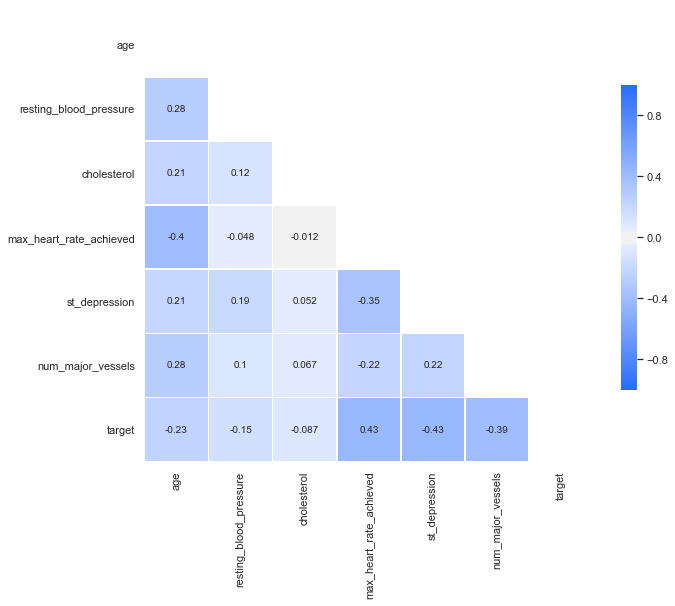

In [10]:
corr = ds.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
cmap = sns.diverging_palette(260, 260, s=100, l=50, n=9, as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-1, center=0, square=True, linewidth=.5, cbar_kws={'shrink': .5}, annot=True, mask=mask, cmap=cmap)
plt.tight_layout()
plt.show()

#### Categorical features handling

##### Dummy fetures creation

In [11]:
ds = pd.get_dummies(ds, drop_first=True)

### Data distriutions

###### Violin Plot

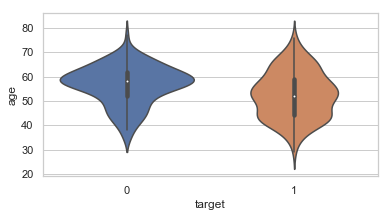

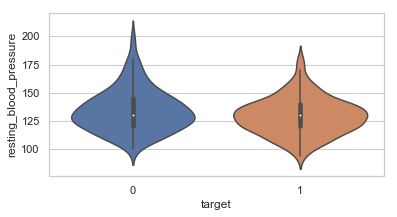

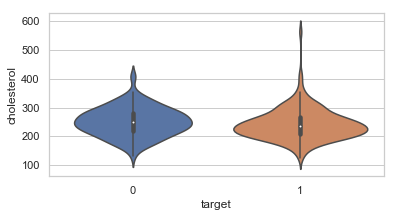

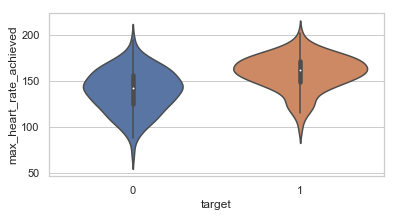

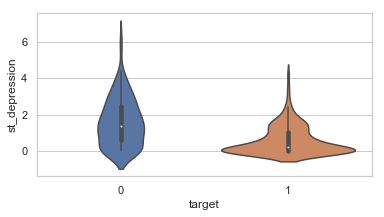

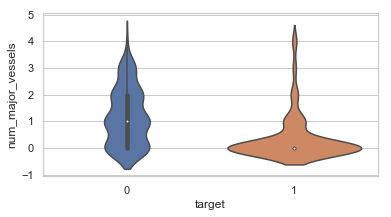

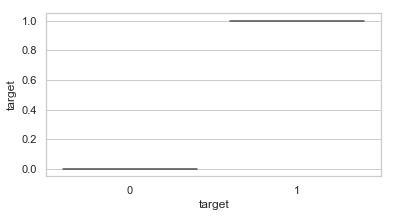

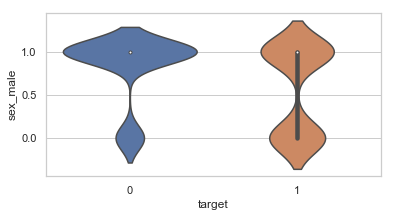

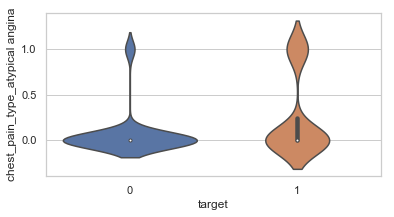

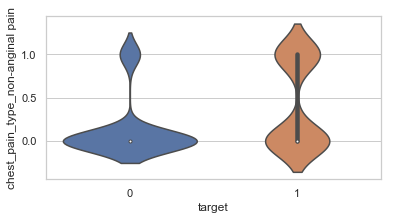

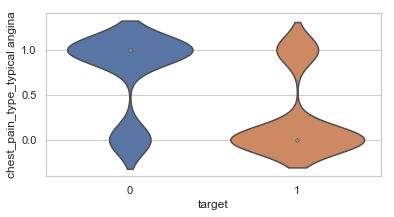

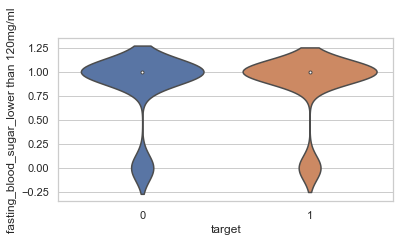

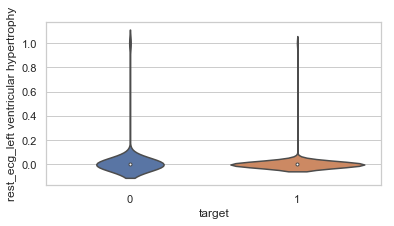

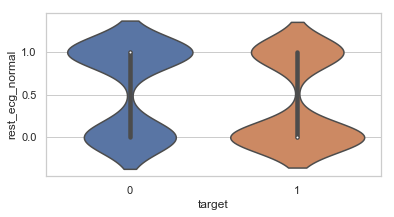

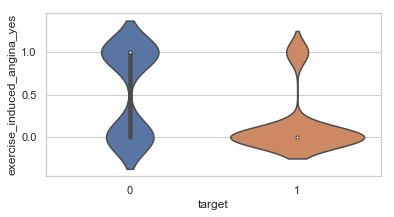

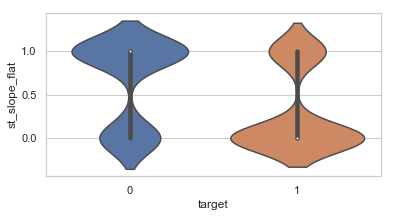

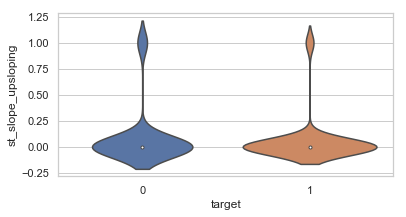

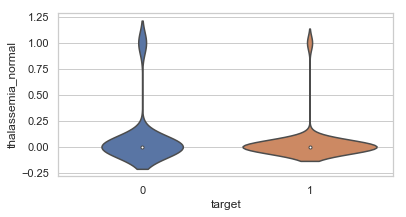

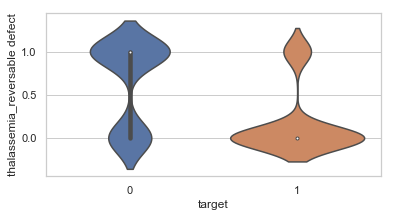

In [12]:
for feature in ds.columns:
    plt.figure(figsize=(6, 3))
    sns.violinplot(y=feature, x="target", data=ds)
    plt.show()

##### Distribution Plot

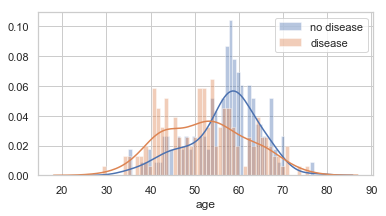

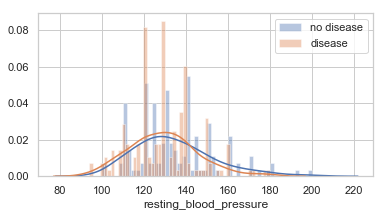

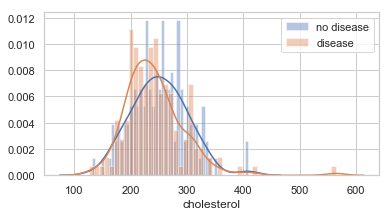

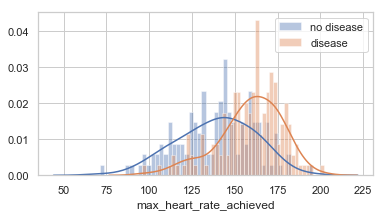

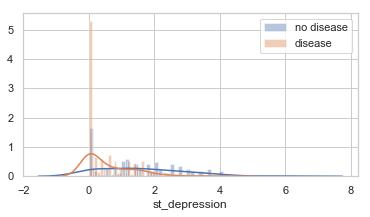

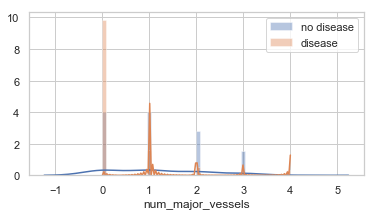

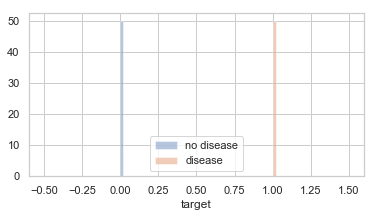

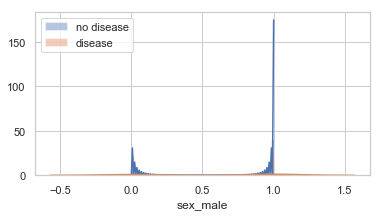

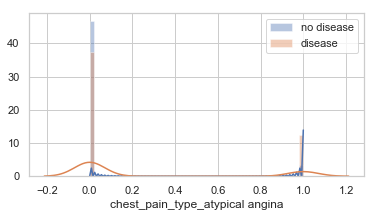

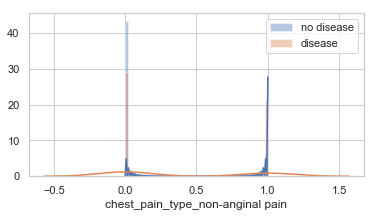

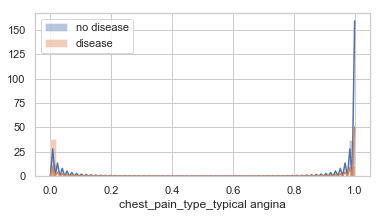

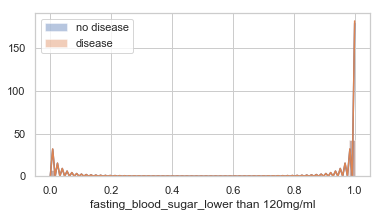

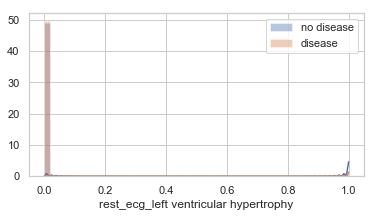

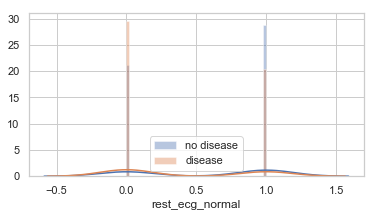

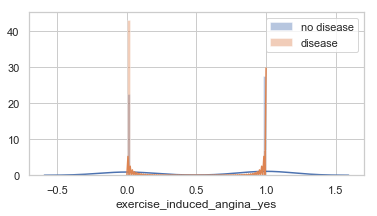

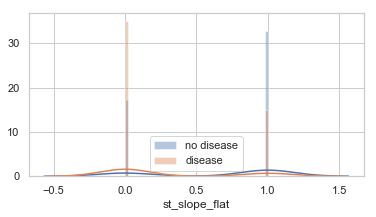

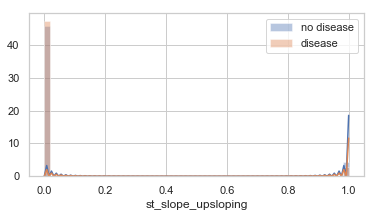

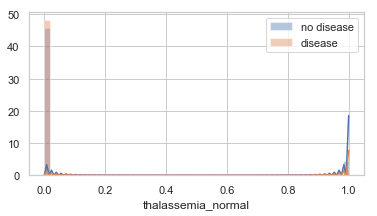

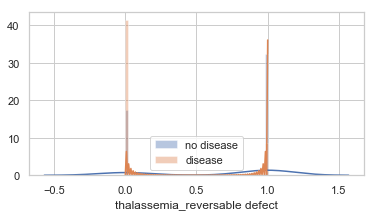

In [13]:
for c in ds.columns:
    plt.figure(figsize=(6, 3))
    sns.distplot(ds[c][ds["target"]==0], hist=True, bins=50, label="no disease")
    sns.distplot(ds[c][ds["target"]==1], hist=True, bins=50, label="disease")
    plt.legend()
    plt.show()

### Data cleaning

In [14]:
print(ds.shape[1])
ds.drop(['rest_ecg_left ventricular hypertrophy', 'thalassemia_normal', 'st_slope_upsloping'], axis=1, inplace=True)
print(ds.shape[1])

19
16


## Model implementation and tuning

##### Split dataset in input values and values to predict

In [15]:
X = ds.drop(['target'], axis=1) # X -> data
Y = ds['target'] # Y -> values to predict

#### Feature importance
Uso RFC per estrarre le features più importanti

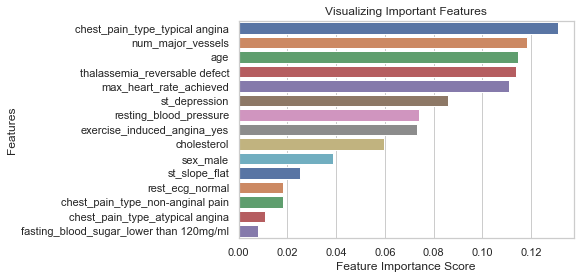

In [16]:
model = RandomForestClassifier(random_state = 50)
do_feature_importance(model, X, Y)

#### Data Normalization

In [17]:
scaler = preprocessing.StandardScaler()
columns_names = X.columns
# Fit your data on the scaler object
X_scaled = X
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=columns_names)
X_scaled.describe()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,thalassemia_reversable defect
count,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,301.000000,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02
mean,8.262125e-17,2.950759e-16,3.835987e-17,-9.442428e-17,0.000000,-2.360607e-17,-2.360607e-17,1.180304e-17,4.721214e-17,9.442428e-17,-1.209811e-16,-1.239319e-16,-7.081821e-17,-2.360607e-17,2.360607e-17
std,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00
min,-2.790159e+00,-2.143374e+00,-2.325019e+00,-3.445541e+00,-0.898179,-7.180170e-01,-1.472556e+00,-4.463218e-01,-6.324555e-01,-9.450300e-01,-2.416797e+00,-9.705336e-01,-6.948083e-01,-9.262962e-01,-7.974143e-01
25%,-8.112244e-01,-6.631372e-01,-6.850318e-01,-6.887884e-01,-0.898179,-7.180170e-01,-1.472556e+00,-4.463218e-01,-6.324555e-01,-9.450300e-01,4.137707e-01,-9.705336e-01,-6.948083e-01,-9.262962e-01,-7.974143e-01
50%,1.782429e-01,-9.381519e-02,-1.062129e-01,1.426132e-01,-0.209384,-7.180170e-01,6.790913e-01,-4.463218e-01,-6.324555e-01,-9.450300e-01,4.137707e-01,-9.705336e-01,-6.948083e-01,-9.262962e-01,-7.974143e-01
75%,7.279470e-01,4.755068e-01,5.497818e-01,7.114670e-01,0.479410,2.599157e-01,6.790913e-01,-4.463218e-01,1.581139e+00,1.058167e+00,4.137707e-01,1.030361e+00,1.439246e+00,1.079568e+00,1.254053e+00
max,2.487000e+00,3.891439e+00,6.125737e+00,2.286754e+00,4.439978,3.193714e+00,6.790913e-01,2.240536e+00,1.581139e+00,1.058167e+00,4.137707e-01,1.030361e+00,1.439246e+00,1.079568e+00,1.254053e+00


### Train Set and Validation Set Split
##### Split train set and test set (train: 75% test: 25%)


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.25, random_state = 50)
print("Train set:", int(np.round(X_train.shape[0]/X.shape[0]*100)), "%  ", "({}/{})".format(X_train.shape[0], X.shape[0]))
print("Test set:", int(np.round(X_test.shape[0]/X.shape[0]*100)), "%   ", "({}/{})".format(X_test.shape[0], X.shape[0]))

Train set: 75 %   (225/301)
Test set: 25 %    (76/301)


##### First attempt without tuning

Accuracy Score (without Hyperparameters Tuning): 80.263%


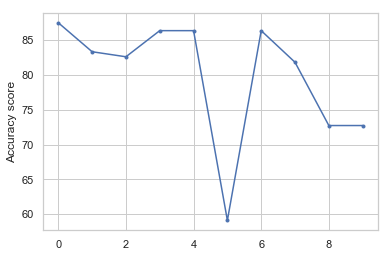

CV Mean Accuracy: 79.8897 %
CV STD Accuracy: 8.612955706956816 %


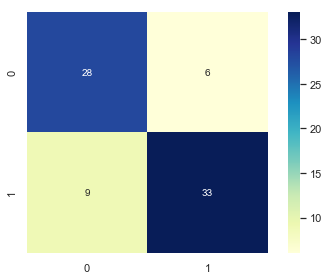

Sensitivity (True Positives Rate): 0.76
Specificity (True Negatives Rate): 0.85


In [19]:
## Accuracy
model = RandomForestClassifier(random_state=50)
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
accuracy = accuracy_score(Y_test, prediction)
print("Accuracy Score (without Hyperparameters Tuning):", "{}%".format(np.round(100*accuracy,3)))

## Cross Validation
model = None
model = RandomForestClassifier(random_state=50)
accuracy = cross_val_score(model, X_train, Y_train, cv = 10, scoring = 'accuracy')
accuracy = np.round(accuracy * 100, 3)

model = None

plt.plot(accuracy, '.-b', label="Training Acc")
plt.ylabel('Accuracy score')
plt.show()
print("CV Mean Accuracy:", np.mean(accuracy), "%")
print("CV STD Accuracy:", np.std(accuracy), "%")

## Confusion Matrix
do_confusion_matrix(Y_test, prediction)

#do_feature_importance(model, X_scaled, Y)

model = None
prediction = None
accuracy = None

### Hyperparameters tuning

##### Hyperparameters define

In [20]:
max_features = list(range(1,X_scaled.shape[1]))
n_estimators = [2, 4, 8, 16, 32, 64, 100, 300]
max_depth = [2, 4, 6, 8, 9, 10, 15, 20]


hyperF = dict(n_estimators=n_estimators,
              max_features=max_features,
              max_depth=max_depth)

#### Validation curve tuning ()

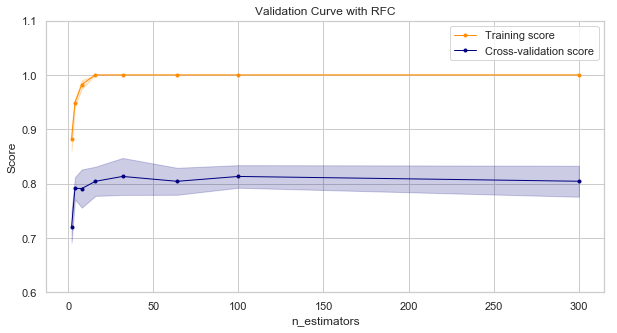

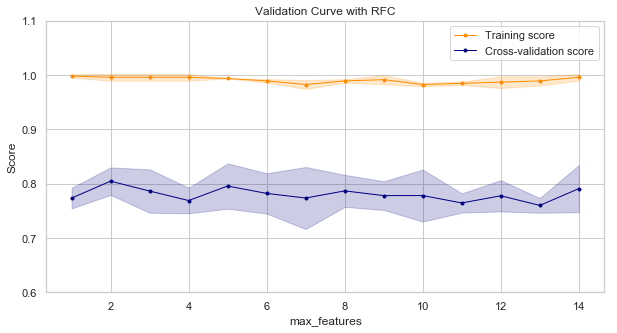

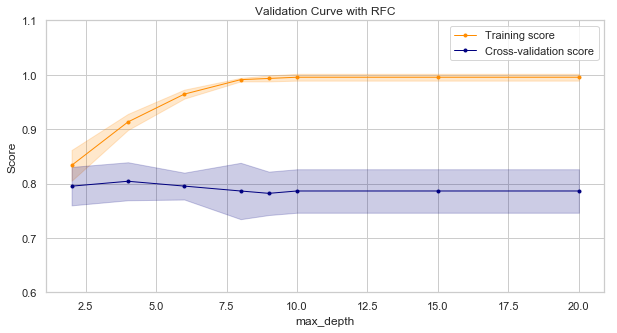

Best Hyperparameters values:
n_estimators :  100
max_features :  2
max_depth :  4


In [21]:
# Tuning n_estimators
best_hyp = dict()
test_scores_mean = do_validation_curve(RandomForestClassifier(random_state=50), X_train, Y_train, 'n_estimators', n_estimators)
best_hyp["n_estimators"] = n_estimators[np.argmax(test_scores_mean)]

# Tuning max_features
test_scores_mean = do_validation_curve(RandomForestClassifier(random_state=50), X_train, Y_train, 'max_features', max_features)
best_hyp["max_features"] = max_features[np.argmax(test_scores_mean)]

## Tuning min_samples_leaf
## test_scores_mean = do_validation_curve(RandomForestClassifier(random_state=50), X_train, Y_train, 'min_samples_leaf', min_samples_leaf)
## print("Best min_samples_leaf:", min_samples_leaf[np.argmax(test_scores_mean)])

## Tuning max_depth
test_scores_mean = do_validation_curve(RandomForestClassifier(random_state=50), X_train, Y_train, 'max_depth', max_depth)

best_hyp["max_depth"] = max_depth[np.argmax(test_scores_mean)]

## Tuning bootstrap
## test_scores_mean = do_validation_curve(RandomForestClassifier(ranbest_hyp["max_features"] = max_features[np.argmax(test_scores_mean)]
## print("Best bootstrap:", bootstrap[np.argmax(test_scores_mean)])

print("Best Hyperparameters values:")
for k in best_hyp:
    print(k, ": ", best_hyp[k])

#### Test set tuning

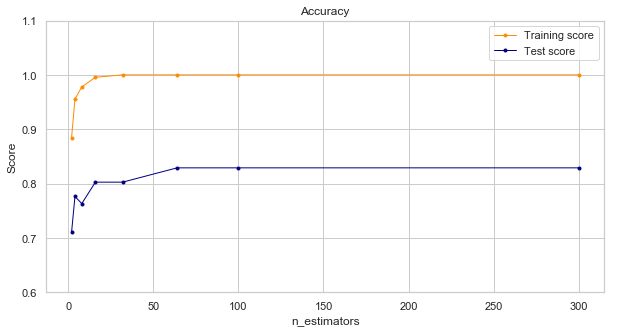

Max Test Score: 82.895
Best Param Value: 64


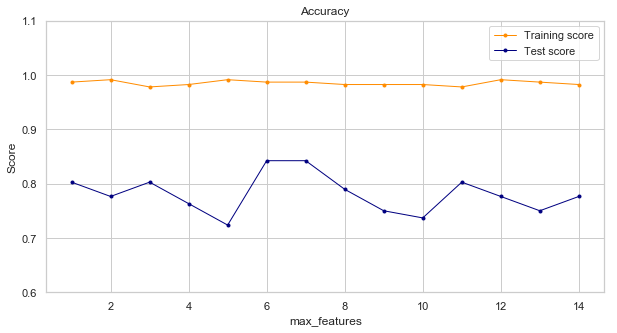

Max Test Score: 84.211
Best Param Value: 6


In [22]:
#################################
#### SBAGLIATO PROBABILMENTE ####
#################################

do_test_set_hyperparameter_tuning(X_train, X_test, Y_train, Y_test, "n_estimators", n_estimators)
do_test_set_hyperparameter_tuning(X_train, X_test, Y_train, Y_test, "max_features", max_features)

#### Exhaustive GridSearchCV Tuning

##### GridSearchCV

In [ ]:
gridF = GridSearchCV(RandomForestClassifier(random_state=50), hyperF, cv = 10, verbose = 1, n_jobs = -1)
bestF = gridF.fit(X_train, Y_train)

Fitting 10 folds for each of 896 candidates, totalling 8960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 1662 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2534 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4534 tasks      | elapsed:  2.8min


##### Cross Validation

In [ ]:
accuracyCV = cross_val_score(bestF, X_train, Y_train, cv = 10, scoring = 'accuracy')

print()
print("*"*50)
print("\n\n")
print("Cross Validation Scores")
plt.plot(accuracyCV, '.-b', label="Accuracy CV")
plt.ylabel('Accuracy score')
plt.show()
print("CV Mean Accuracy Score:", np.round(np.mean(100*accuracyCV), 3), "%")
print()
print("*"*50)
print("\n\n")

##### Best Hyperparameters

In [160]:
for (k,i) in bestF.best_params_.items():
    print(k,": ",i)

max_depth :  9
max_features :  1
n_estimators :  16


#### Test Set and Cross Vaidation Performances

##### Test Set

Accuracy Score (with Hyperparameters Tuning): 86.842%


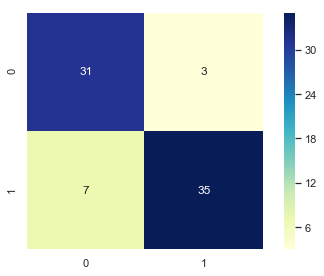

Sensitivity (True Positives Rate): 0.82
Specificity (True Negatives Rate): 0.92


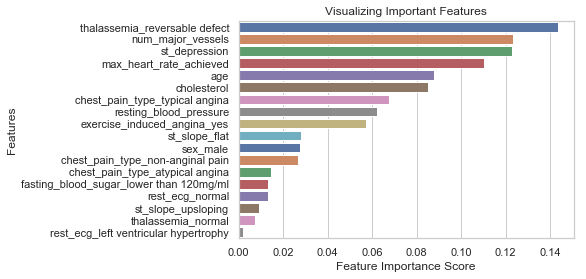

In [169]:
model = RandomForestClassifier(random_state=50, criterion='gini',
                               #n_estimators=bestF.best_estimator_.n_estimators,
                               n_estimators=bestF.best_estimator_.n_estimators,
                               #max_features=bestF.best_estimator_.max_features,
                               max_features=3,
                               max_depth=bestF.best_estimator_.max_depth)

model = model.fit(X_train, Y_train)
prediction = model.predict(X_test)
accuracy = accuracy_score(Y_test, prediction)
print("Accuracy Score (with Hyperparameters Tuning):", "{}%".format(np.round(100*accuracy,3)))

do_confusion_matrix(Y_test, prediction)
do_feature_importance(model, X_scaled, Y)

model = None
prediction = None
accuracy = None



##### Cross Validation

Cross Validation Scores


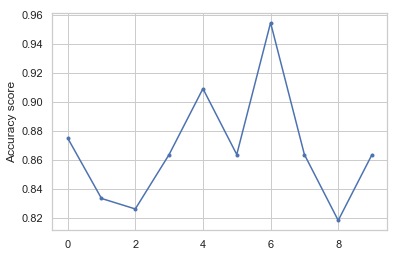

CV Mean Accuracy Score: 86.708 %
CV STD Accuracy Score: 3.839 %


In [166]:
model = RandomForestClassifier(random_state=50, criterion='gini',
                               n_estimators=bestF.best_estimator_.n_estimators,
                               max_features=bestF.best_estimator_.max_features,
                               max_depth=bestF.best_estimator_.max_depth)



accuracyCV = cross_val_score(model, X_train, Y_train, cv = 10, scoring = 'accuracy')
print("Cross Validation Scores")
plt.plot(accuracyCV, '.-b', label="Accuracy CV")
plt.ylabel('Accuracy score')
plt.show()
print("CV Mean Accuracy Score:", np.round(100*np.mean(accuracyCV), 3), "%")
print("CV STD Accuracy Score:", np.round(100*np.std(accuracyCV), 3), "%")
model = None
accuracyCV = None